In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from metric import *

%matplotlib notebook
import matplotlib.pyplot as plt

In [2]:
pre_processing = False

In [3]:
no_cuda = False
device = torch.device("cuda" if torch.cuda.is_available() and not no_cuda else "cpu")

<h1> Sepsis Dataset </h1>

<h3> Load </h3>

In [32]:
## CSV from: https://www.kaggle.com/code/salikhussaini49/read-data-from-directory
df = pd.read_csv('data/dataset.csv')
df.drop(['Unnamed: 0', 'EtCO2', 'BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN', 'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct', 'Lactate', 'Magnesium', 'Phosphate', 'Potassium', 'Potassium', 'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'PTT', 'WBC', 'Fibrinogen', 'Platelets', 'Unit1', 'Unit2'], axis=1, inplace=True)

<h3> Understanding </h3>

In [33]:
df.head()

,Hour,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,Glucose,Age,Gender,HospAdmTime,ICULOS,SepsisLabel,Patient_ID
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,68.54,0,-0.02,1,0,17072
1,1,65.0,100.0,NaN,NaN,72.0,NaN,16.5,NaN,68.54,0,-0.02,2,0,17072
2,2,78.0,100.0,NaN,NaN,42.5,NaN,NaN,NaN,68.54,0,-0.02,3,0,17072
3,3,73.0,100.0,NaN,NaN,NaN,NaN,17.0,NaN,68.54,0,-0.02,4,0,17072
4,4,70.0,100.0,NaN,129.0,74.0,69.0,14.0,161.0,68.54,0,-0.02,5,0,17072


In [34]:
df.describe()

,Hour,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,Glucose,Age,Gender,HospAdmTime,ICULOS,SepsisLabel,Patient_ID
count,1.552210e+06,1.398811e+06,1.349474e+06,525226.000000,1.325945e+06,1.358940e+06,1.065656e+06,1.313875e+06,265516.000000,1.552210e+06,1.552210e+06,1.552202e+06,1.552210e+06,1.552210e+06,1.552210e+06
mean,2.549274e+01,8.458144e+01,9.719395e+01,36.977228,1.237505e+02,8.240010e+01,6.383056e+01,1.872650e+01,136.932283,6.200947e+01,5.592690e-01,-5.612512e+01,2.699499e+01,1.798468e-02,5.920148e+04
std,2.888256e+01,1.732524e+01,2.936924e+00,0.770014,2.323156e+01,1.634175e+01,1.395601e+01,5.098194e+00,51.310728,1.638622e+01,4.964749e-01,1.622569e+02,2.900542e+01,1.328956e-01,5.024819e+04
min,0.000000e+00,2.000000e+01,2.000000e+01,20.900000,2.000000e+01,2.000000e+01,2.000000e+01,1.000000e+00,10.000000,1.400000e+01,0.000000e+00,-5.366860e+03,1.000000e+00,0.000000e+00,1.000000e+00
25%,9.000000e+00,7.200000e+01,9.600000e+01,36.500000,1.070000e+02,7.100000e+01,5.400000e+01,1.500000e+01,106.000000,5.168000e+01,0.000000e+00,-4.705000e+01,1.100000e+01,0.000000e+00,9.990000e+03
50%,1.900000e+01,8.350000e+01,9.800000e+01,37.000000,1.210000e+02,8.000000e+01,6.200000e+01,1.800000e+01,127.000000,6.400000e+01,1.000000e+00,-6.030000e+00,2.100000e+01,0.000000e+00,1.996500e+04
75%,3.300000e+01,9.550000e+01,9.950000e+01,37.500000,1.380000e+02,9.200000e+01,7.200000e+01,2.150000e+01,153.000000,7.400000e+01,1.000000e+00,-4.000000e-02,3.400000e+01,0.000000e+00,1.098780e+05
max,3.350000e+02,2.800000e+02,1.000000e+02,50.000000,3.000000e+02,3.000000e+02,3.000000e+02,1.000000e+02,988.000000,1.000000e+02,1.000000e+00,2.399000e+01,3.360000e+02,1.000000e+00,1.200000e+05


In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1552210 entries, 0 to 1552209
Data columns (total 15 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   Hour         1552210 non-null  int64  
 1   HR           1398811 non-null  float64
 2   O2Sat        1349474 non-null  float64
 3   Temp         525226 non-null   float64
 4   SBP          1325945 non-null  float64
 5   MAP          1358940 non-null  float64
 6   DBP          1065656 non-null  float64
 7   Resp         1313875 non-null  float64
 8   Glucose      265516 non-null   float64
 9   Age          1552210 non-null  float64
 10  Gender       1552210 non-null  int64  
 11  HospAdmTime  1552202 non-null  float64
 12  ICULOS       1552210 non-null  int64  
 13  SepsisLabel  1552210 non-null  int64  
 14  Patient_ID   1552210 non-null  int64  
dtypes: float64(10), int64(5)
memory usage: 177.6 MB


<h1> Pre-processing </h1>

<h3> Replace missing values with forward and backward fill </h3>

In [36]:
if (pre_processing) :
    # Forward and Backward fill on patient
    for patientId in df['Patient_ID'].unique():
        df.loc[df['Patient_ID'] == patientId] = df.loc[df['Patient_ID'] == patientId].ffill().bfill()

<h3> Standardization </h3>

In [37]:
if (pre_processing) :
    from sklearn import preprocessing

    min_max_scaler = preprocessing.MinMaxScaler()
    scaled_data = min_max_scaler.fit_transform(df.loc[:, df.columns != 'Patient_ID'].to_numpy())
    df.loc[:, df.columns != 'Patient_ID'] = scaled_data

<h3> Replace missing columns with the closest line </h3>

In [38]:
if (pre_processing) :
    clean_dataframe = df[~df.isnull().any(axis=1)]

    for patientId in df['Patient_ID'].unique():
        patient_data = df[df['Patient_ID'] == patientId]
        missing_columns = patient_data.columns[patient_data.isna().any()].tolist()

        index = 0       
        first_index = patient_data.index[0] 

        if(len(missing_columns) > 0):
            taked_columns = clean_dataframe.columns.difference(missing_columns)

            for v in patient_data[taked_columns].drop(['Patient_ID'], axis=1).values:    
                diff_df = clean_dataframe[clean_dataframe['Patient_ID'] != patientId][taked_columns].drop(['Patient_ID'], axis=1) - v
                diff_df = diff_df.abs()

                if(len(diff_df) == 0):
                    print("Aucun patient similaire")
                    df.loc[first_index + index, missing_columns] = df[missing_columns].mean().tolist()
                else:
                    df.loc[first_index + index, missing_columns] = df.iloc[diff_df.sum(axis=1).idxmin()][missing_columns].tolist()

                index += 1

                if((first_index + index) % (len(df) / 10) == 0):
                    df.to_csv('data/pre_processed_dataset' + str(((first_index + index) / (len(df))) * 100) + '.csv', index = False)


In [4]:
if (pre_processing) :
    df.to_csv('data/pre_processed_dataset.csv', index = False)
else :
    df = pd.read_csv('data/pre_processed_dataset.csv')

<h3> Visualize normalized dataset </h3>

In [4]:
df.head()

,Hour,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,Glucose,Age,Gender,HospAdmTime,ICULOS,SepsisLabel,Patient_ID
0,0.000000,0.173077,1.0,0.51134,0.389286,0.185714,0.175,0.156566,0.154397,0.634186,0.0,0.995546,0.000000,0.0,17072
1,0.002985,0.173077,1.0,0.51134,0.389286,0.185714,0.175,0.156566,0.154397,0.634186,0.0,0.995546,0.002985,0.0,17072
2,0.005970,0.223077,1.0,0.51134,0.389286,0.080357,0.175,0.156566,0.154397,0.634186,0.0,0.995546,0.005970,0.0,17072
3,0.008955,0.203846,1.0,0.51134,0.389286,0.080357,0.175,0.161616,0.154397,0.634186,0.0,0.995546,0.008955,0.0,17072
4,0.011940,0.192308,1.0,0.51134,0.389286,0.192857,0.175,0.131313,0.154397,0.634186,0.0,0.995546,0.011940,0.0,17072


In [5]:
df.describe()

,Hour,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,Glucose,Age,Gender,HospAdmTime,ICULOS,SepsisLabel,Patient_ID
count,1.552210e+06,1.552210e+06,1.552210e+06,1.552210e+06,1.552210e+06,1.552210e+06,1.552210e+06,1.552210e+06,1.552210e+06,1.552210e+06,1.552210e+06,1.552210e+06,1.552210e+06,1.552210e+06,1.552210e+06
mean,7.609774e-02,2.475758e-01,9.644500e-01,5.483841e-01,3.703352e-01,2.240038e-01,1.561501e-01,1.783596e-01,1.245711e-01,5.582496e-01,5.592690e-01,9.851387e-01,7.759699e-02,1.798468e-02,5.920148e+04
std,8.621659e-02,6.690260e-02,3.888962e-02,2.480953e-02,8.320588e-02,5.865927e-02,4.991229e-02,5.216514e-02,4.871073e-02,1.905374e-01,4.964749e-01,3.009851e-02,8.658334e-02,1.328956e-01,5.024819e+04
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
25%,2.686567e-02,2.000000e-01,9.500000e-01,5.326460e-01,3.107143e-01,1.821429e-01,1.214286e-01,1.464646e-01,9.509202e-02,4.381395e-01,0.000000e+00,9.868221e-01,2.985075e-02,0.000000e+00,9.990000e+03
50%,5.671642e-02,2.423077e-01,9.750000e-01,5.463918e-01,3.607143e-01,2.178571e-01,1.500000e-01,1.717172e-01,1.145194e-01,5.813953e-01,1.000000e+00,9.944313e-01,5.970149e-02,0.000000e+00,1.996500e+04
75%,9.850746e-02,2.884615e-01,9.875000e-01,5.635739e-01,4.214286e-01,2.571429e-01,1.857143e-01,2.020202e-01,1.411043e-01,6.976744e-01,1.000000e+00,9.955424e-01,9.850746e-02,0.000000e+00,1.098780e+05
max,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.200000e+05


<h1> Split and Format Dataset </h1>

<h3> Split into train and test set </h3>

In [5]:
from sklearn.model_selection import train_test_split

samplelist = df["Patient_ID"].unique()
training_samp, test_samp = train_test_split(samplelist, train_size=0.7, test_size=0.3, random_state=5, shuffle=True)
    
train_df = df[df['Patient_ID'].isin(training_samp)]
test_df = df[df['Patient_ID'].isin(test_samp)]

<h3> Split dataset per patient </h3>

In [ ]:
window_size = 6

In [6]:
train_data = []
train_label = []

for patientId in train_df['Patient_ID'].unique():
    tmp_data = train_df[train_df['Patient_ID'] == patientId]
    if(len(tmp_data) >= window_size):
        train_data.append(tmp_data.drop(['Hour', 'Patient_ID', 'SepsisLabel'], axis=1).to_numpy())
        train_label.append(tmp_data['SepsisLabel'].to_numpy())

In [28]:
test_data = []
test_label = []

for patientId in test_df['Patient_ID'].unique():
    tmp_data = test_df[test_df['Patient_ID'] == patientId]
    if(len(tmp_data) >= window_size):
        test_data.append(tmp_data.drop(['Hour', 'Patient_ID', 'SepsisLabel'], axis=1).to_numpy())
        test_label.append(tmp_data['SepsisLabel'].to_numpy())

In [7]:
print("train size:", len(train_data))
print("test size:", len(test_data))

28235

<h3> TimeSeries dataset </h3>

In [8]:
train_labels = []

# One patient per batch
train_loader = []

for i in range(len(train_data)):
    patient_data = train_data[i]
    labels = train_label[i]
    X_data = []
    Y_data = []
    
    for j in range(len(patient_data) - (window_size - 1)):
        X_data.append(patient_data[j:(j + window_size)])
        Y_data.append([labels[(j + window_size - 1)]])
        train_labels.append(labels[(j + window_size - 1)])
    
    train_loader.append([torch.Tensor(X_data), torch.Tensor(Y_data)])

In [29]:
test_labels = []

# One patient per batch
test_loader = []

for i in range(len(test_data)):
    patient_data = test_data[i]
    labels = test_label[i]
    X_data = []
    Y_data = []
    
    for j in range(len(patient_data) - (window_size - 1)):
        X_data.append(patient_data[j:(j + window_size)])
        Y_data.append([labels[(j + window_size - 1)]])
        test_labels.append(labels[(j + window_size - 1)])
    
    test_loader.append([torch.Tensor(X_data), torch.Tensor(Y_data)])

<h1> Transfomer </h1>

In [24]:
# SOURCE: https://github.com/LiamMaclean216/Pytorch-Transfomer/blob/master/Transformer.ipynb
from transformer.utils import *
from transformer.Network import *

# Hyperparams
enc_seq_len = 1 # 6 # length of input given to encoder. Can have any integer value.
dec_seq_len = 6 # 2 # length of input given to decoder. Can have any integer value.
output_sequence_length = 1 # 1 # Length of the target sequence, i.e. how many time steps should your forecast cover

input_size = 12 # Multivariate forecasting.
dim_val = 10
dim_attn = 5

lr = 0.002
epochs = 6 # 20

n_heads = 4 # The number of attention heads (aka parallel attention layers). dim_val must be divisible by this number

n_decoder_layers = 0
n_encoder_layers = 4

# Init network and optimizer
t = Transformer(dim_val, dim_attn, input_size, dec_seq_len, output_sequence_length, n_decoder_layers, n_encoder_layers, n_heads)
t = t.to(device) 
optimizer = torch.optim.Adam(t.parameters(), lr=lr)

In [88]:
%%capture
t.load_state_dict(torch.load("weights/epoch50.w"))
t.eval()

In [25]:
def convertIntoBinary(pred):
    pred = nn.functional.sigmoid(pred) # pred in ]0, 1[
    pred = nn.functional.threshold(pred, 0.5, 0.0) # pred in 0 or ]0.5, 1[
    pred = torch.sub(torch.tensor(1.0), pred) # pred in ]0, 0.5[ or 1
    pred = nn.functional.threshold(pred, 0.5, 0.0) # pred in 0 or 1 (reverted)
    pred = torch.sub(torch.tensor(1.0), pred) # pred in 0 or 1
    return pred

In [26]:
trainLossWeight = torch.tensor([train_labels.count(0) / train_labels.count(1)]).to(device)

# Keep track of loss
losses = []
    
for e in range(epochs):
    print("Starting epoch: " + str(e))
    out = []
    
    for b in train_loader:
        optimizer.zero_grad()
        X, Y = b
        X = X.to(device)
        Y = Y.to(device)
        
        # Forward pass
        pred = t(X)     
        pred = convertIntoBinary(pred)  # pred in 0 or 1
               
        # Loss
        criterion = nn.BCEWithLogitsLoss(pos_weight = trainLossWeight)
        loss = criterion(pred, Y)
        
        # Backwards pass
        loss.backward()
        optimizer.step()
        
        # Track losses
        out.append([pred.detach().cpu().numpy(), Y])
        losses.append(loss.detach().cpu().numpy())

Starting epoch: 0
Starting epoch: 1
Starting epoch: 2
Starting epoch: 3
Starting epoch: 4
Starting epoch: 5


In [27]:
torch.save(t.state_dict(), "weights/epoch6.w")

<h1> Score </h1>

<h3> Compute losses </h3>

In [30]:
test_preds = []
utility_loss = []

for b in test_loader:
    X, Y = b
    X = X.to(device)
    Y = Y.to(device)

    pred = t(X).to(device)
    pred = convertIntoBinary(pred)  # pred in 0 or 1
    
    utility_loss = np.append(utility_loss, compute_prediction_utility(pred.detach().cpu().numpy().flatten(), Y))

    test_preds = np.append(test_preds, pred.detach().cpu().flatten())

D:\Logiciels\anaconda3\envs\cuda_test\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [ ]:
testLossWeight = (test_labels.count(0) / test_labels.count(1))
criterion = nn.BCEWithLogitsLoss(pos_weight = torch.tensor(testLossWeight))

In [31]:
print("BCEWithLogits loss: ", criterion(torch.tensor(test_preds), torch.tensor(test_labels))) # 1.3508

tensor(1.3611, dtype=torch.float64)

In [32]:
print("Physionet loss: ", sum(utility_loss) / len(utility_loss)) # -9.24

-0.030547062226262144


In [33]:
res = torch.tensor(0.0)

for _, w in t.state_dict().items():
    res = torch.add(res, w.abs().sum())
    
print("sum of weights: ", res) #34845.1094

tensor(32739.8867, device='cuda:0')


<IPython.core.display.Javascript object>


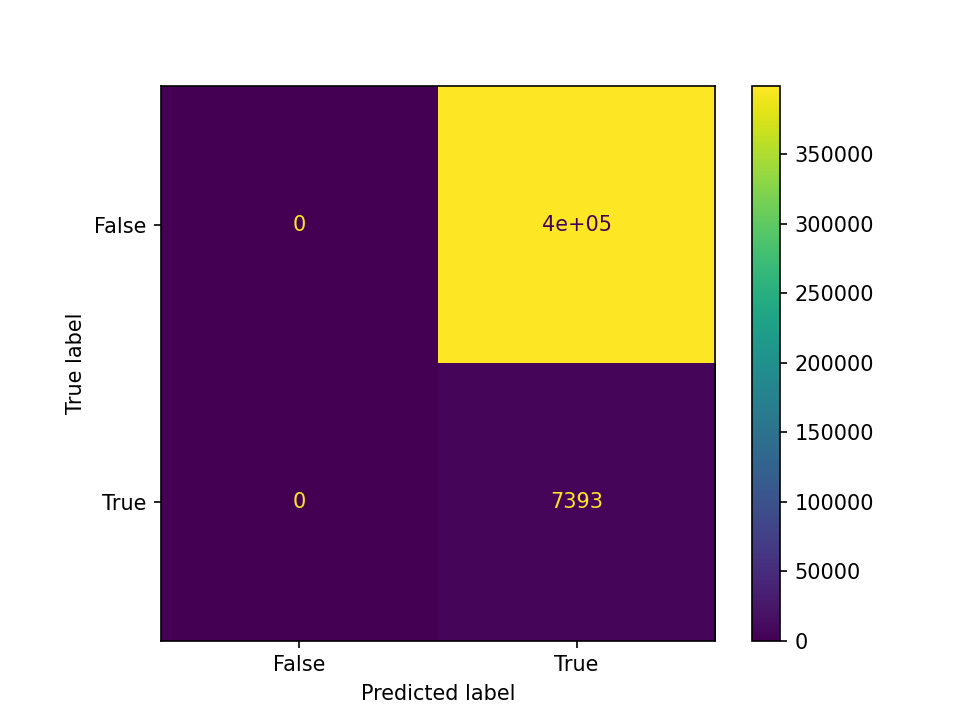

In [54]:
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(test_labels, test_preds)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()

In [ ]:
def l21_norm(W): 
    return torch.sum(torch.linalg.norm(W, dim=-1))

def get_group_regularization(mlp_model):
    const_coeff = lambda W: torch.sqrt(torch.tensor(W.size(dim=-1), dtype=torch.float32))
    return torch.sum(torch.tensor([torch.multiply(const_coeff(W), l21_norm(W)) for name, W in t.named_parameters() if 'bias' not in name]))

def sparse_group_lasso(mlp_model):
    grouplasso = get_group_regularization(mlp_model)
    l1 = torch.linalg.norm(torch.concat([torch.reshape(x[1] ,[-1]) for x in t.named_parameters()], dim=0))
    sparse_lasso = grouplasso + l1
    return sparse_lasso

def f1_norm(feat, label, mlp_model):
    cross_entropy_norm = nn.CrossEntropyLoss()(torch.tensor(label), mlp_model(torch.tensor(feat)))
    return cross_entropy_norm

def f2_norm(max_b, mlp_model):
    s_g_l = sparse_group_lasso(mlp_model)
    sparse_group_lasso_norm = s_g_l / max_b
    return sparse_group_lasso_norm